<a href="https://colab.research.google.com/github/sapotomate/Style-transfer-with-coocurrence-tensors/blob/main/Transferencia_de_estilos_CONCURRENCIAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red de transferencia de estilos

In [27]:
import os
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
from torch.autograd import Variable
from PIL import Image
import math

Generamos nuestra clase modelo de red neuronal (en este caso creamos ambas partes de obtencion de características y de clasificacion, aunque solo usaremos la primera) junto con diccionarios de nombres de las capas, los cuales con ayuda de la funcion build_sequential() creamos el esqueleto y con el .pth la poblamos

In [28]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

channel_list = {
'VGG-19': [64, 64, 'P', 128, 128, 'P', 256, 256, 256, 256, 'P', 512, 512, 512, 512, 'P', 512, 512, 512, 512, 'P'],
}

vgg19_dict = {
'C': ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4'],
'R': ['relu1_1', 'relu1_2', 'relu2_1', 'relu2_2', 'relu3_1', 'relu3_2', 'relu3_3', 'relu3_4', 'relu4_1', 'relu4_2', 'relu4_3', 'relu4_4', 'relu5_1', 'relu5_2', 'relu5_3', 'relu5_4'],
'P': ['pool1', 'pool2', 'pool3', 'pool4', 'pool5'],
}

def buildSequential(channel_list, pooling):
    layers = []
    in_channels = 3
    if pooling == 'max':
        pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
    elif pooling == 'avg':
        pool2d = nn.AvgPool2d(kernel_size=2, stride=2)
    else:
        raise ValueError("Parametro de pooling incorrecto")
    for c in channel_list:
        if c == 'P':
            layers += [pool2d]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c
    return nn.Sequential(*layers)


Creamos una instancia de la red, junto con algunas opciones para facilitar la ejecución en un pc local:

In [29]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True #cambiar a false en caso de fallo
dtype = torch.cuda.FloatTensor
backward_device = "cuda:0"
device = "cuda"

pooling = 'max'

cnn, layerList = VGG(buildSequential(channel_list['VGG-19'], pooling)), vgg19_dict
cnn.load_state_dict(torch.load('/content/vgg19-d01eb7cb.pth'))
cnn = cnn.cuda()
cnn = cnn.features

Ahora vamos a incluir las imagenes que vamos a utilizar en la red y su tamaño, para preprocesarlas posteriormente

In [30]:
input_content = '/content/golden_gate.jpg'
input_style = '/content/starry_night.jpg'

#image_size = 512
image_size = tuple([380, 512])

Vamos a construir dos funciones compuestas por tuberías (sucesiones de operaciones) para preparar las imágenes para entrar en la red (normalización, transofrmación a tensor, rangos 0..255, etc.) y otra para revertir esa preparación una vez ha salido de la red y devolverla a su formato original (revertir de tensor a imagen)

In [31]:
def preprocesamiento(image_name, image_size):
    image = Image.open(image_name).convert('RGB')
    if type(image_size) is not tuple:
        image_size = tuple([int((float(image_size) / max(image.size))*x) for x in (image.height, image.width)])
    Loader = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    rgb2bgr = transforms.Compose([transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])]) #pasar de RGB a BGR
    Normalize = transforms.Compose([transforms.Normalize(mean=[103.939, 116.779, 123.68], std=[1,1,1])]) #restar la media dada de la base de datos imagenet
    tensor = Normalize(rgb2bgr(Loader(image) * 255)).unsqueeze(0)
    return tensor


def postprocesamiento(output_tensor):
    Normalize = transforms.Compose([transforms.Normalize(mean=[-103.939, -116.779, -123.68], std=[1,1,1])]) #sumar la media dada de la base de datos imagenet
    bgr2rgb = transforms.Compose([transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])])   #pasar de BGR a RGB
    output_tensor = bgr2rgb(Normalize(output_tensor.squeeze(0).cpu())) / 255
    output_tensor.clamp_(0, 1)
    Image2PIL = transforms.ToPILImage()
    image = Image2PIL(output_tensor.cpu())
    return image

Finalmente vamos a cargar las imágenes de entrada y a crear la imagen target, la imagen de salida con la mezcla de estilo y contenido, para ya centrarnos en la red

* Podemos crear la imagen target de dos maneras, que empiece como un tensor aleatorio o que parta de una imagen dada

In [32]:
#content_image = Image.open(input_content)
#style_image = Image.open(input_style).convert('RGB')

content_image = preprocesamiento(input_content,image_size)
style_image = preprocesamiento(input_style,image_size)

content_image = content_image.cuda()
style_image = style_image.cuda()

#Variable(content_image.unsqueeze(0).cuda())
#Variable(style_image.unsqueeze(0).cuda())


b, c, h, w = content_image.size()

target_image = torch.randn(c, h, w).mul(0.001).unsqueeze(0).type(dtype).cuda() #imagen aleatoria
#target_image = content_image.clone().cuda() #partir de la imagen de contenido de entrada (puede llegar a dar mejores resultados)

In [33]:
print(target_image.size())
print(content_image.size())
print(style_image.size())

torch.Size([1, 3, 380, 512])
torch.Size([1, 3, 380, 512])
torch.Size([1, 3, 380, 512])


## Módulos para agregar a nuestra red

A continuacion vamos a definir los módulos que necesitamos para ejecutar la transferencia

###  Módulo para calcular la Matriz de Gram

La salida de cada capa convolucional es un Tensor con dimensiones b, d, h, w:
- b: batch_size (cantidad de muestras que se pasan a la red de una, en nuestro caso usualmente será 1)
- d: depth (profundidad del Tensor) // puede tratarse tambien como la cantidad de canales (c: channels)
- h: height (altura del Tensor)
- w: width (anchura del Tensor)

Para calcular la matriz de Gram, tenemos que conseguir esos parámetros de nuestro Tensor, y crear uno nuevo pero de diferente tamaño, agrupandose de la siguiente manera:

Tensor de tamaño (b x d, h x w)

Ahora hay que realizar el producto escalar de los mapas de características en sus dos dimensiones, para cada capa convolucional

In [34]:
class GramMatrix(nn.Module):

    def forward(self, input):
        B, C, H, W = input.size()
        x_flat = input.view(C, H * W)
        return torch.mm(x_flat, x_flat.t())

### Módulo para aplicar un filtro de concurrencias

Vamos a sustituir el uso de la matriz de Gram con el cálculo de tensores de concurrencias para intentar mejorar el resultado final de la imagen, en el que vamos a dar un radio de ventana deslizante y el numero de canales de los que se van a calcular las concurrencias entre sí

In [35]:
class CoOccurrenceFilter(nn.Module):

    def __init__(self, channels, cooc_r, out_shape):
        super(CoOccurrenceFilter, self).__init__()
        self.radius = cooc_r
        self.channels = channels
        cooc_w = self.radius * 2 + 1
        cooc_filter = np.ones((channels, channels, 1, 1))#/math.pow(cooc_w, 2)
        for i in range(channels):
            cooc_filter[i, i, :, :] = 0 #1e-10
        cooc_filter = torch.FloatTensor(cooc_filter).cuda()
        cooc_filter = cooc_filter.repeat(1, 1, cooc_w, cooc_w)
        self.cooc_filter = cooc_filter
        self.shape = out_shape

    def forward(self, input):

        act_m = input > torch.mean(input)
        act = input * act_m.float()

        #act = input*aux.float()
        cooc_map = torch.nn.functional.conv2d(act, self.cooc_filter, padding = self.radius)

        cooc_map = cooc_map / (input.shape[1] - 1)
        cooc_map = cooc_map * act_m.float() #aux.float()

        if self.shape == "raw":
            B, C, H, W = cooc_map.size()
            cooc_gram_flat = cooc_map.view(C, H * W)
            return  torch.mm(cooc_gram_flat, cooc_gram_flat.t())
            ##return cooc_map
        elif self.shape == "vector":
            cooc_map = torch.mean(cooc_map, dim = [2,3])
            return cooc_map
        elif self.shape == "matrix":
            cooc_map = torch.mean(cooc_map, dim = [0,1])
            cooc_map = torch.div(cooc_map, torch.sum(cooc_map)) ##normalización de la matriz
            return cooc_map
        else:
            ##Devolvemos el tensor por defecto original
            return cooc_map
        #return cooc_map

### Módulo para calcular el error en el contenido de la imagen

Para calcular el error del contenido se calcula la distancia cuadrática media entre la imagen contenido y la imagen objetivo (ruido aleatorio u imagen predefinida)

In [36]:
class ContentLoss(nn.Module):

    def __init__(self, strength):
        super(ContentLoss, self).__init__()
        self.strength = strength
        self.crit = nn.MSELoss()
        self.mode = 'None'

    def forward(self, input):
        if self.mode == 'loss':
            loss = self.crit(input, self.target)
            self.loss = loss * self.strength
        elif self.mode == 'capture':
            self.target = input.detach()
        return input

### Módulo para calcular el error en el estilo de la imagen

Para calcular el error de la imagen primero se tiene que calcular el error cuadratico medio de cada capa de la matriz de Gram con la imagen objetivo e ir sumando esos errores multiplicados por el peso asociado a cada capa convolucional de la red

In [37]:
class StyleLoss(nn.Module):

    def __init__(self, strength):
        super(StyleLoss, self).__init__()
        self.target = torch.Tensor()
        self.strength = strength
        self.gram = GramMatrix()        
        self.crit = nn.MSELoss()
        self.mode = 'None'
        self.cooc = True #True si quieres usar concurrencias, false si qieres Gram

    def forward(self, input):
        if self.cooc:
            radius = 3
            shape = "raw"  #raw, matrix o vector
            _, channels, _, _ = input.size()
            aux = CoOccurrenceFilter(channels, radius, shape)
            self.G = aux(input)
        else:
            self.G = self.gram(input)
        self.G = self.G.div(input.nelement())
        #print(self.G)
        if self.mode == 'capture':
            self.target = self.G.detach()
        elif self.mode == 'loss':
            loss = self.crit(self.G, self.target)
            self.loss = self.strength * loss
        return input


### Capas de la red neuronal a utilizar

Además de pesos generalizados para el contenido y el estilo, seleccionamos también las capas de la red que utilizaremos para calcular las pérdidas segun el artículo

Por otra parte, vamos a asignar un peso de 1/5 a cada capa de la que se va a extraer características del estilo

In [38]:
content_layers = ['relu4_2']
content_weight = 1e0
style_layers = ['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1']
style_weight = 1e2

Ahora vamos a introducir en la red los módulos de cálculo de error de contenido y estilo

In [39]:
cnn = copy.deepcopy(cnn)
content_losses, style_losses = [], []
next_content_idx, next_style_idx = 1, 1
net = nn.Sequential().cuda()
c, r, p = 0, 0, 0

layerList = vgg19_dict

for i, layer in enumerate(list(cnn), 1):
    if next_content_idx <= len(content_layers) or next_style_idx <= len(style_layers):
        if isinstance(layer, nn.Conv2d):
            net.add_module(str(len(net)), layer)
            if layerList['C'][c] in content_layers:
                print("Agregada capa de contenido convolucional " + str(i) + ": " + str(layerList['C'][c]))
                loss_module = ContentLoss(content_weight)
                net.add_module(str(len(net)), loss_module)
                content_losses.append(loss_module)
            if layerList['C'][c] in style_layers:
                print("Agregada capa de estilo convolucional " + str(i) + ": " + str(layerList['C'][c]))
                loss_module = StyleLoss(style_weight)
                net.add_module(str(len(net)), loss_module)
                style_losses.append(loss_module)
            c+=1

        if isinstance(layer, nn.ReLU):
            net.add_module(str(len(net)), layer)

            if layerList['R'][r] in content_layers:
                print("Agregada capa de contenido ReLU " + str(i) + ": " + str(layerList['R'][r]))
                loss_module = ContentLoss(content_weight)
                net.add_module(str(len(net)), loss_module)
                content_losses.append(loss_module)
                next_content_idx += 1

            if layerList['R'][r] in style_layers:
                print("Agregada capa de estilo ReLu " + str(i) + ": " + str(layerList['R'][r]))
                loss_module = StyleLoss(style_weight)
                net.add_module(str(len(net)), loss_module)
                style_losses.append(loss_module)
                next_style_idx += 1
            r+=1

        if isinstance(layer, nn.MaxPool2d) or isinstance(layer, nn.AvgPool2d):
            print("Agregada capa de pooling " + str(i) + ": " + str(layerList['P'][p]))
            net.add_module(str(len(net)), layer)
            p+=1

Agregada capa de estilo ReLu 2: relu1_1
Agregada capa de pooling 5: pool1
Agregada capa de estilo ReLu 7: relu2_1
Agregada capa de pooling 10: pool2
Agregada capa de estilo ReLu 12: relu3_1
Agregada capa de pooling 19: pool3
Agregada capa de estilo ReLu 21: relu4_1
Agregada capa de contenido ReLU 23: relu4_2
Agregada capa de pooling 28: pool4
Agregada capa de estilo ReLu 30: relu5_1


Vamos a ver lo que hemos conseguido con esto.
* En primer lugar hemos obtenido una nueva red que intercala la extracción de características con la obtencion de errores y pooling
    * Podemos observar que a la hora de avanzar en la red automáticamente calculará los errores tras recibir las características obtenidas por la aplicación del filtro correspondiente de la capa convolucional y su función de activación ReLU
    * Los módulos del calculo de error se introducen después de detectar una de las capas de pérdida para calcular el error que hemos definido anteriormente

* En segundo lugar hemos obtenido un array "style_losses" el cual ha guardado la sucesion de los 5 módulos tras las capas que hemos indicado anteriormente para calcular el error del estilo
    * Como se indica en el artículo, una parte del cálculo del error del estilo es calcular el error por separado de cada capa haciendo uso de las matrices de Gram tanto de la imagen objetivo como de la de estilo y mas tarde sumar todas ellas con sus respectivos pesos por capa

* En tercer lugar hemos obtenido un array "content_losses" con el mismo principio que el anterior, solo que en este simplemente se va a calcular el error cuadrático medio entre las características del contenido y las de la imagen objetivo

In [40]:
#red obtenida
print("Red obtenida: \n", net)
print("Calculos de error de estilo\n",style_losses)
print("Calculos de error de contenido\n",content_losses)

Red obtenida: 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): StyleLoss(
    (gram): GramMatrix()
    (crit): MSELoss()
  )
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): StyleLoss(
    (gram): GramMatrix()
    (crit): MSELoss()
  )
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): StyleLoss(
    (gram): GramMatrix()
    (crit): MSELoss()
  )
  (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace=

### Captura de características del contenido

Como podemos observar en la implementación del modulo de calculo de las perdidas en el contenido, éste tiene un atributo 'mode', el cual va a dictar si va a capturar (capture) o a calcular el error (loss). Pues bien ahora vamos a iterar sobre el array de módulos 'content_losses' que hemos obtenido anteriormente e indicar el modo que queremos en ellos.

Una vez indicado el modo pasamos a ejecutar nuestra red obtenida anteriormente con nuestra imagen de contenido. (Nótese que utilizamos solo los modulos de error de contenido ya que el resto por defecto tienen el atributo a none)

Finalmente vamos a devolver los modos del array de modulos a su estado original.

In [41]:
for i in content_losses:
    i.mode = 'capture'

net(content_image)

for i in content_losses:
    i.mode = 'None'

### Captura de características del estilo

Ahora vamos a repetir lo mismo pero con el array de módulos de calculo de las perdidas en el estilo (cambiar atributos 'mode' de none a capture, ejecutar la red con la imagen de estilo y devolver los modos a su estado original)

In [42]:
for i in style_losses:
    i.mode = 'capture'

net(style_image)

for i in style_losses:
    i.mode = 'None'

### Preparar la red para el calculo de los errores

* Vamos a dejar la red preparada para cuando incorporemos el optimizador, para ello, como anteriormente vamos a poner los modos de todos los módulos a pérdida (loss)

* Vamos también a congelar los parámetros de la red para evitar los cálculos del gradiente en segundo plano y que ralentizarán bastante el modelo

* Por último vamos a pasar nuestro tensor de imagen objetivo a módulo de red neuronal

In [43]:
for i in content_losses:
    i.mode = 'loss'
for i in style_losses:
    i.mode = 'loss'

for param in net.parameters():
    param.requires_grad = False

target_image = nn.Parameter(target_image)

### Optimizador

Tenemos que construir un optimizador para tratar de ir cambiando cada iteracion los pesos que se inician aleatoriamente al principio de la ejecucion, de manera que a lo largo de la ejecucion aumentamos la precision de la red

‎En cada iteracion, la salida de los datos de entrenamiento se compara con los datos reales con la ayuda de la función de pérdida (o error) para calcular el error y luego el peso se actualiza en consecuencia utilizando dicho optimizador.‎

En este caso elegimos el optimizador basado en el algoritmo L-BFGS, utiilizado por defecto en el codigo que implementa el artículo, con los siguientes parámetros

* Introducimos la imagen objetivo
* Introducimos la tasa de aprendizaje
* Introducimos las iteraciones maximas, en este caso las 1000 por defecto que se utilizan en el articulo
* Introducimos una tolerancia de cambio, (tolerancia de terminación en‎‎ los cambios de valor/parámetro de la función)
* Introducimos una tolerancia de gradiente, (tolerancia de terminación en la optimalidad de primer orden‎)

In [44]:
optimizer = optim.LBFGS([target_image], lr = 0.3, max_iter = 10000, tolerance_change = -1, tolerance_grad = -1)
#optimizer = optim.LBFGS([target_image], lr = 0.1, max_iter = 10000, tolerance_change = -1, tolerance_grad = -1)
loopVal = 1

### Ejecución del programa

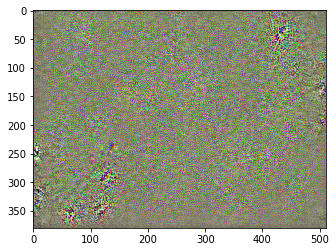

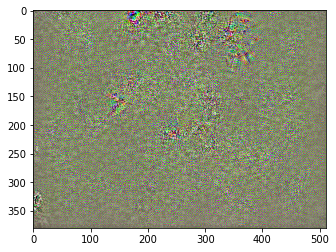

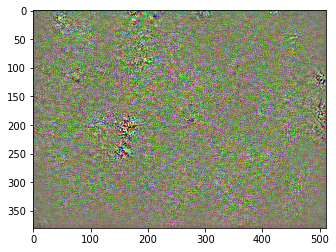

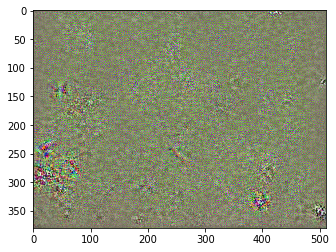

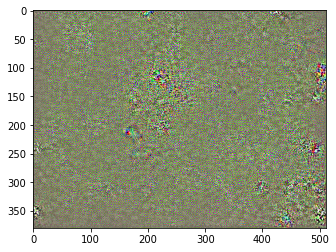

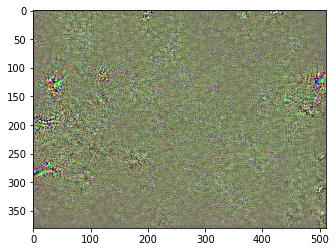

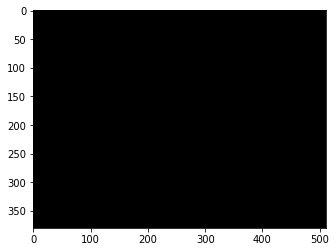

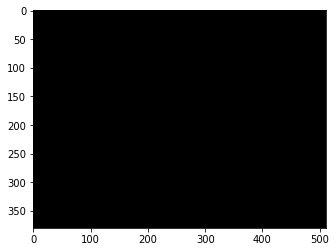

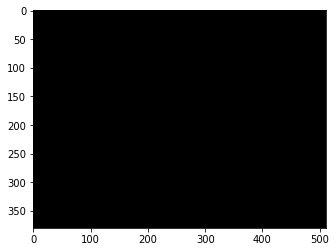

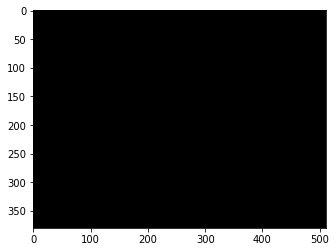

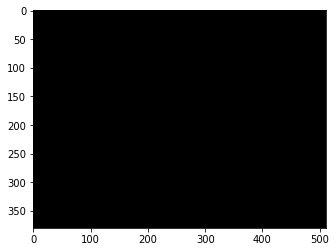

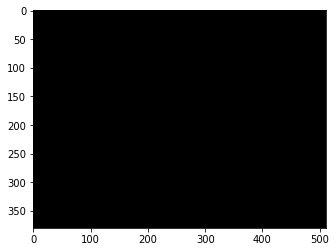

In [ ]:
def maybe_save(t):
    #should_save = 100 > 0 and t % 100 == 0
    #should_save = should_save or t == 1000
    should_save = t == 1000
    if should_save:
        output_filename, file_extension = os.path.splitext('output.jpg')
        if t == 50000:
            filename = output_filename + str(file_extension)
        else:
            filename = str(output_filename) + "_" + str(t) + str(file_extension)
        disp = postprocesamiento(target_image.clone())

        disp.save(str(filename))

def maybe_show(t):
    if t % 500 == 0:
        plt.imshow(postprocesamiento(target_image))
        plt.show()        

num_calls = [0]
def closure():
    num_calls[0] += 1
    optimizer.zero_grad()
    net(target_image)
    loss = 0

    for module in content_losses:
        loss += module.loss.to(backward_device)
    for module in style_losses:
        loss += module.loss.to(backward_device)

    loss.backward()

    maybe_save(num_calls[0])
    maybe_show(num_calls[0])

    return loss


while num_calls[0] <= loopVal:
        optimizer.step(closure)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(postprocesamiento(content_image))
ax2.imshow(postprocesamiento(style_image))
ax3.imshow(postprocesamiento(target_image))
plt.show()